<a href="https://colab.research.google.com/github/swapnilmn/Assignment_1-CS6910/blob/master/Assignment_1_Question8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 8 (5 Marks) In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

# Libraries 

In [2]:
!wget -O Question_3_.ipynb https://raw.githubusercontent.com/swapnilmn/Assignment_1-CS6910/master/Question_3_.ipynb?token=GHSAT0AAAAAAB7DKQRJB42HZRD4WEXOE4QSZAIV6RA
!pip install import_ipynb
import import_ipynb
import Question_3_ as NN
from Question_3_  import FFNN
!pip install wandb
import wandb
wandb.login()

--2023-03-08 15:53:23--  https://raw.githubusercontent.com/swapnilmn/Assignment_1-CS6910/master/Question_3_.ipynb?token=GHSAT0AAAAAAB7DKQRJB42HZRD4WEXOE4QSZAIV6RA
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104827 (102K) [text/plain]
Saving to: ‘Question_3_.ipynb’

Question_3_.ipynb   100%[===================>] 102.37K  --.-KB/s    in 0.003s  

2023-03-08 15:53:23 (30.8 MB/s) - ‘Question_3_.ipynb’ saved [104827/104827]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
importing Jupyter notebook from Question_3_.ipynb
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: Currently logged in as: ed22s009. Use `wandb login --relogin` to force relogin


(54000, 10) (6000, 10) (10000, 10)
(54000, 784) (6000, 784) (10000, 784)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# Train Function

  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 5, Train Loss: 0.13555675265563655, Train Accuracy: 0.6874259259259259, Val Loss: 0.13605968411329328, Val Accuracy: 0.6765
Model trained successfully !


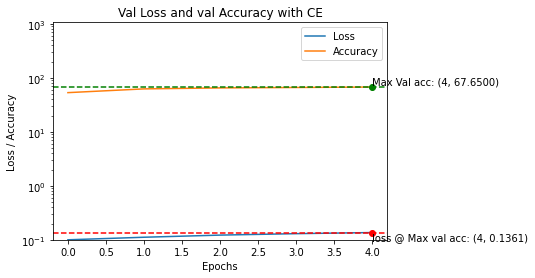

accuracy,▁▅▇▇█
epoch,▁▃▅▆█
loss,▁▃▅▇█
val_accuracy,▁▅▇▇█
val_loss,▁▃▅▇█
accuracy,0.68743
epoch,5
loss,0.13556
val_accuracy,0.6765
val_loss,0.13606


  0%|          | 0/5 [00:00<?, ?epoch/s]

Epoch: 5, Train Loss: 1.4829765865697406, Train Accuracy: 0.652537037037037, Val Loss: 1.494165088715437, Val Accuracy: 0.6376666666666667
Model trained successfully !


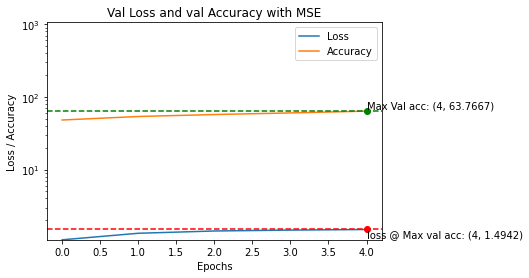

In [3]:
wandb.init(project = 'Question_4_Best_Model')
model = FFNN(NN.X_train, NN.Y_train,
                  epochs = 5, 
                  hidden_layer_count = 3,
                  hidden_layers =  [64, 64, 64],
                  learning_rate = 0.0001,
                  batch_size = 32,
                  activation='Relu',
                  weight_init='random',
                  loss = 'CE',
                  weight_decay = 0.0005)
model.fit(NN.X_train, NN.Y_train, NN.X_val, NN.Y_val,algo= 'Adam', a = 1, show_loss = True)
wandb.init(project = 'Question_4_Best_Model')
model = FFNN(NN.X_train, NN.Y_train,
                  epochs = 5, 
                  hidden_layer_count = 3,
                  hidden_layers =  [64, 64, 64],
                  learning_rate = 0.0001,
                  batch_size = 32,
                  activation='Relu',
                  weight_init='random',
                  loss = 'MSE',
                  weight_decay = 0.0005)
model.fit(NN.X_train, NN.Y_train, NN.X_val, NN.Y_val,algo= 'Adam', a = 1, show_loss = True)